<a href="https://colab.research.google.com/github/GeneSUN/time-series-analysis-toolkit/blob/main/ml_time_series_single_series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install darts

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.3/60.3 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.3/46.3 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 20.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.6/200.6 kB 21.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 825.4/825.4 kB 59.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 44.2 MB/s eta 0:00:00


In [ ]:
# === Download utility scripts from GitHub ===
!wget -q -O metrics.py \
    https://raw.githubusercontent.com/GeneSUN/time-series-analysis-toolkit/main/src/Evaluation/metrics.py

!wget -q -O missing_values.py \
    https://raw.githubusercontent.com/GeneSUN/time-series-analysis-toolkit/main/src/Imputation/missing_values.py

!wget -q -O plot_predictions_vs_actuals.py \
    https://raw.githubusercontent.com/GeneSUN/time-series-analysis-toolkit/main/src/Evaluation/plot_predictions_vs_actuals.py

!wget -q -O feature_importance.py \
    https://raw.githubusercontent.com/GeneSUN/time-series-analysis-toolkit/main/src/Evaluation/feature_importance.py


# === Import functions from the downloaded scripts ===
from metrics import calculate_metrics
from missing_values import missing_summary
from plot_predictions_vs_actuals import plot_predictions_vs_actuals
from feature_importance import plot_feature_importance


In [ ]:
from dataclasses import MISSING, dataclass, field
from typing import List, Optional, Iterable
import pandas as pd
import copy
import warnings
from typing import Dict, List, Union
from pathlib import Path
from tqdm.autonotebook import tqdm

/tmp/ipython-input-3352079583.py:8: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


# 1). Single Model

In [ ]:
import pandas as pd

train_url = "https://raw.githubusercontent.com/GeneSUN/time-series-analysis-toolkit/main/Data/sample_train.csv"
test_url = "https://raw.githubusercontent.com/GeneSUN/time-series-analysis-toolkit/main/Data/sample_test.csv"

sample_train_df = pd.read_csv(train_url)
sample_test_df = pd.read_csv(test_url)

print(sample_train_df.shape, sample_test_df.shape)
display(sample_train_df.head())
display(sample_test_df.head())


(34750, 91) (1488, 91)


,timestamp,LCLid,energy_consumption,frequency,series_length,stdorToU,Acorn,Acorn_grouped,file,holidays,...,timestamp_Minute_sin_1,timestamp_Minute_sin_2,timestamp_Minute_sin_3,timestamp_Minute_sin_4,timestamp_Minute_sin_5,timestamp_Minute_cos_1,timestamp_Minute_cos_2,timestamp_Minute_cos_3,timestamp_Minute_cos_4,timestamp_Minute_cos_5
0,2012-01-08 01:00:00,MAC000193,0.038,30min,37872,ToU,ACORN-D,Affluent,block_7,NO_HOLIDAY,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.0,1.0,1.0,1.0,1.0
1,2012-01-08 01:30:00,MAC000193,0.007,30min,37872,ToU,ACORN-D,Affluent,block_7,NO_HOLIDAY,...,5.665539e-16,-1.133108e-15,2.143751e-15,-2.266215e-15,6.123234e-16,-1.0,1.0,-1.0,1.0,-1.0
2,2012-01-08 02:00:00,MAC000193,0.034,30min,37872,ToU,ACORN-D,Affluent,block_7,NO_HOLIDAY,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.0,1.0,1.0,1.0,1.0
3,2012-01-08 02:30:00,MAC000193,0.040,30min,37872,ToU,ACORN-D,Affluent,block_7,NO_HOLIDAY,...,5.665539e-16,-1.133108e-15,2.143751e-15,-2.266215e-15,6.123234e-16,-1.0,1.0,-1.0,1.0,-1.0
4,2012-01-08 03:00:00,MAC000193,0.019,30min,37872,ToU,ACORN-D,Affluent,block_7,NO_HOLIDAY,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.0,1.0,1.0,1.0,1.0


,timestamp,LCLid,energy_consumption,frequency,series_length,stdorToU,Acorn,Acorn_grouped,file,holidays,...,timestamp_Minute_sin_1,timestamp_Minute_sin_2,timestamp_Minute_sin_3,timestamp_Minute_sin_4,timestamp_Minute_sin_5,timestamp_Minute_cos_1,timestamp_Minute_cos_2,timestamp_Minute_cos_3,timestamp_Minute_cos_4,timestamp_Minute_cos_5
0,2014-01-01 00:00:00,MAC000193,0.223,30min,37872,ToU,ACORN-D,Affluent,block_7,New Year?s Day,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.0,1.0,1.0,1.0,1.0
1,2014-01-01 00:30:00,MAC000193,0.274,30min,37872,ToU,ACORN-D,Affluent,block_7,New Year?s Day,...,5.665539e-16,-1.133108e-15,2.143751e-15,-2.266215e-15,6.123234e-16,-1.0,1.0,-1.0,1.0,-1.0
2,2014-01-01 01:00:00,MAC000193,0.308,30min,37872,ToU,ACORN-D,Affluent,block_7,New Year?s Day,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.0,1.0,1.0,1.0,1.0
3,2014-01-01 01:30:00,MAC000193,0.279,30min,37872,ToU,ACORN-D,Affluent,block_7,New Year?s Day,...,5.665539e-16,-1.133108e-15,2.143751e-15,-2.266215e-15,6.123234e-16,-1.0,1.0,-1.0,1.0,-1.0
4,2014-01-01 02:00:00,MAC000193,0.000,30min,37872,ToU,ACORN-D,Affluent,block_7,New Year?s Day,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.0,1.0,1.0,1.0,1.0


1. which features we are going to use
2. if categorical features, boolean features

In [ ]:
missing_summary(sample_train_df)

,column,n_missing,pct_missing


In [ ]:
#@title feature_dict
feature_dict = {
    "continuous_features": (
        [
            "visibility",
            "windBearing",
            "temperature",
            "dewPoint",
            "pressure",
            "apparentTemperature",
            "windSpeed",
            "humidity",
        ]
        # --- lag features ---
        + [f"energy_consumption_lag_{i}" for i in [1, 2, 3, 4, 5, 46, 47, 48, 49, 50, 334, 335, 336, 337, 338]]
        # --- rolling stats ---
        + [f"energy_consumption_rolling_{w}_mean" for w in [3, 6, 12, 48]]
        + [f"energy_consumption_rolling_{w}_std" for w in [3, 6, 12, 48]]
        # --- seasonal rolling stats ---
        + [f"energy_consumption_48_seasonal_rolling_{w}_{stat}" for w in [3] for stat in ["mean", "std"]]
        + [f"energy_consumption_336_seasonal_rolling_{w}_{stat}" for w in [3] for stat in ["mean", "std"]]
        # --- timestamp encodings ---
        + ["timestamp_Elapsed"]
        + [f"timestamp_Month_{kind}_{i}" for kind in ["sin", "cos"] for i in range(1, 6)]
        + [f"timestamp_Hour_{kind}_{i}" for kind in ["sin", "cos"] for i in range(1, 6)]
        + [f"timestamp_Minute_{kind}_{i}" for kind in ["sin", "cos"] for i in range(1, 6)]
    ),

    "categorical_features": [
        "holidays",
        "precipType",
        "icon",
        "summary",
        "timestamp_Month",
        "timestamp_Quarter",
        "timestamp_WeekDay",
        "timestamp_Dayofweek",
        "timestamp_Dayofyear",
        "timestamp_Hour",
        "timestamp_Minute",
    ],

    "boolean_features": [
        "timestamp_Is_quarter_end",
        "timestamp_Is_quarter_start",
        "timestamp_Is_year_end",
        "timestamp_Is_year_start",
        "timestamp_Is_month_start",
    ],

    "date": ["timestamp"],

    "exogenous_features": [
        "holidays",
        "precipType",
        "icon",
        "summary",
        "visibility",
        "windBearing",
        "temperature",
        "dewPoint",
        "pressure",
        "apparentTemperature",
        "windSpeed",
        "humidity",
    ],
}


## sklearn.pipeline = Transformer + Model

In [ ]:
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import Ridge

preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), feature_dict["continuous_features"]),
        ("cat", OneHotEncoder(handle_unknown="ignore"), feature_dict["categorical_features"] ),
        ("bool", "passthrough", feature_dict["boolean_features"]),
    ],
    remainder="drop"
)


model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("regressor", Ridge(alpha=1.0))
])




## Evaluation

In [ ]:

X = sample_train_df[feature_dict["continuous_features"] + feature_dict["categorical_features"] + feature_dict["boolean_features"]]
y = sample_train_df["energy_consumption"]

model.fit(X, y)


y_pred = model.predict(sample_test_df[feature_dict["continuous_features"] + feature_dict["categorical_features"] + feature_dict["boolean_features"]])
print(y_pred[:5])

metrics_dict = calculate_metrics(y = sample_test_df["energy_consumption"], y_pred=pd.Series(y_pred), name= "Ridge", y_train = y)

[0.02641551 0.03979435 0.08265759 0.12447722 0.11159905]


In [ ]:
fig = plot_predictions_vs_actuals(
    y_pred,
    sample_test_df["energy_consumption"],
    sample_test_df["timestamp"],
    metrics=metrics_dict,
    extra_title="Validation set: Household A",
    date_range=("2014-01-01", "2014-01-08")
)
fig.show()



```
 'MAE': np.float64(0.166),
 'RMSE': np.float64(0.274),
 'WAPE': np.float64(0.473),
 'MASE': np.float64(1.292),
 'Forecast Bias(%)': np.float64(4.029)}
```



## Feature Importance

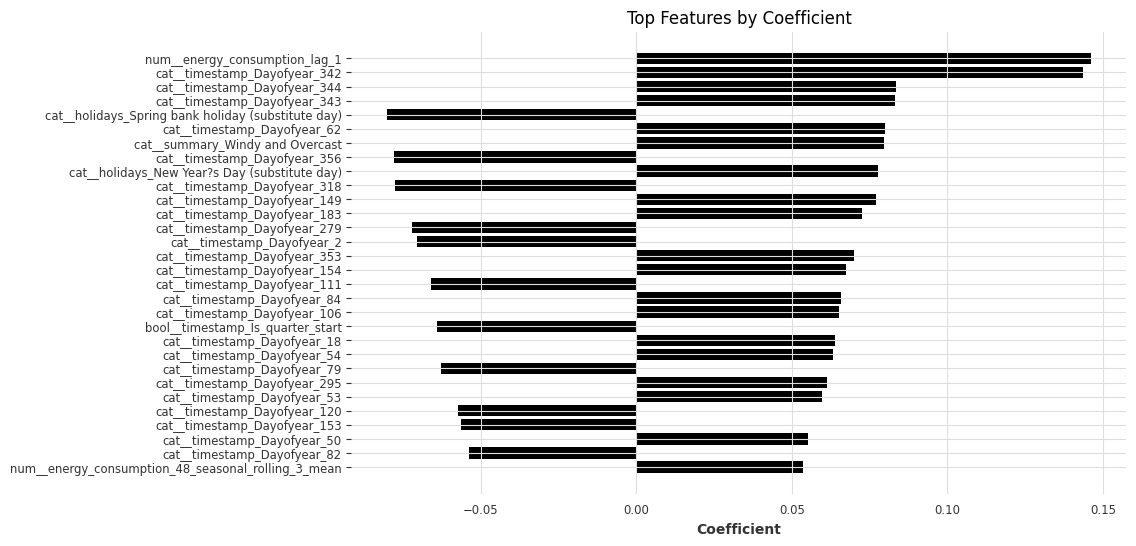

In [ ]:
coef_df = plot_feature_importance(model, top_n=30)



# 2). Running ML Forecast for all consumers

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Colab Notebooks/Time_Series/data

Mounted at /content/drive
/content/drive/MyDrive/Colab Notebooks/Time_Series/data


In [ ]:

preprocessed = Path("data/london_smart_meters/preprocessed")
output = Path("data/london_smart_meters/output")

train_df = pd.read_parquet(preprocessed/"selected_blocks_train_missing_imputed_feature_engg.parquet")
test_df = pd.read_parquet(preprocessed/"selected_blocks_val_missing_imputed_feature_engg.parquet")


In [ ]:
"""
!pip install -q gdown

import gdown


def download_parquet_from_drive(file_id: str, output: str) -> pd.DataFrame:

    url = f"https://drive.google.com/uc?id={file_id}"
    gdown.download(url, output, quiet=False)
    return pd.read_parquet(output)

train_file_id = "1TwzeFcAQwW0CjTXUkjCNvBIm91m9qWOM"
test_file_id  = "1szb_UPNtiNHNMEtysM5K9WXcHD4zlZVF"

train_df = download_parquet_from_drive(train_file_id, "train_df.parquet")
test_df  = download_parquet_from_drive(test_file_id, "test_df.parquet")
"""


'\n!pip install -q gdown\n\nimport gdown\n\n\ndef download_parquet_from_drive(file_id: str, output: str) -> pd.DataFrame:\n\n    url = f"https://drive.google.com/uc?id={file_id}"\n    gdown.download(url, output, quiet=False)\n    return pd.read_parquet(output)\n\ntrain_file_id = "1TwzeFcAQwW0CjTXUkjCNvBIm91m9qWOM"\ntest_file_id  = "1szb_UPNtiNHNMEtysM5K9WXcHD4zlZVF"\n\ntrain_df = download_parquet_from_drive(train_file_id, "train_df.parquet")\ntest_df  = download_parquet_from_drive(test_file_id, "test_df.parquet")\n'

In [ ]:
#@title 1.ModelRunner
import pandas as pd
from tqdm import tqdm
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler

class ModelRunner:
    def __init__(self, feature_dict, model_cls, model_params=None,
                 use_scaler=True, use_onehot=True):
        self.feature_dict = feature_dict
        self.model_cls = model_cls
        self.model_params = model_params or {}
        self.use_scaler = use_scaler
        self.use_onehot = use_onehot
        self.pipeline = self._build_pipeline()

    def _build_pipeline(self):
        transformers = []

        if self.use_scaler and self.feature_dict["continuous_features"]:
            transformers.append(("num", StandardScaler(), self.feature_dict["continuous_features"]))
        elif self.feature_dict["continuous_features"]:
            transformers.append(("num", "passthrough", self.feature_dict["continuous_features"]))

        if self.use_onehot and self.feature_dict["categorical_features"]:
            transformers.append(("cat", OneHotEncoder(handle_unknown="ignore"), self.feature_dict["categorical_features"]))
        elif self.feature_dict["categorical_features"]:
            transformers.append(("cat", "passthrough", self.feature_dict["categorical_features"]))

        if self.feature_dict["boolean_features"]:
            transformers.append(("bool", "passthrough", self.feature_dict["boolean_features"]))

        preprocessor = ColumnTransformer(transformers, remainder="drop")
        model = self.model_cls(**self.model_params)

        return Pipeline(steps=[
            ("preprocessor", preprocessor),
            ("regressor", model)
        ])

    def fit(self, X, y):
        self.pipeline.fit(X, y)

    def predict(self, X):
        return self.pipeline.predict(X)


In [ ]:
from sklearn.linear_model import Lasso

# Define model configs
model_configs = {
    "Lasso": {
        "cls": Lasso,
        "params": {"alpha": 0.1},   # set alpha manually (no CV here)
        "use_scaler": True,
        "use_onehot": True
    },
}

# Pick model and initialize runner
runner = ModelRunner(
    feature_dict=feature_dict,
    model_cls=model_configs["Lasso"]["cls"],
    model_params=model_configs["Lasso"].get("params", {}),
    use_scaler=model_configs["Lasso"].get("use_scaler", True),
    use_onehot=model_configs["Lasso"].get("use_onehot", True)
)



In [ ]:

X = sample_train_df[feature_dict["continuous_features"]
                    + feature_dict["categorical_features"]
                    + feature_dict["boolean_features"]]
y = sample_train_df["energy_consumption"]

runner.fit(X, y)


preds_df = runner.predict(sample_test_df[feature_dict["continuous_features"] + feature_dict["categorical_features"] + feature_dict["boolean_features"]])


In [ ]:
preds_df

array([0.20105573, 0.21493031, 0.22712048, ..., 0.22079666, 0.23124103,
       0.25479705])

In [ ]:
del model_configs, runner, X, y, preds_df

## 2.Evaluate Function

In [ ]:
def run_model_for_customer(model_runner, model_name, lcl_id, train_df, test_df, feature_dict):
    train_data = train_df[train_df["LCLid"] == lcl_id]
    test_data  = test_df[test_df["LCLid"] == lcl_id]

    X_train = train_data[
        feature_dict["continuous_features"]
        + feature_dict["categorical_features"]
        + feature_dict["boolean_features"]
    ]
    y_train = train_data["energy_consumption"]

    X_test = test_data[
        feature_dict["continuous_features"]
        + feature_dict["categorical_features"]
        + feature_dict["boolean_features"]
    ]
    y_test = test_data["energy_consumption"]

    # fit + predict
    model_runner.fit(X_train, y_train)
    y_pred = model_runner.predict(X_test)

    # predictions
    preds_df = pd.DataFrame({
        "LCLid": lcl_id,
        "timestamp": test_data["timestamp"].values,
        "y_true": y_test.values,
        "y_pred": y_pred,
        "model": model_name
    })

    # metrics
    m = calculate_metrics(
        y=y_test,
        y_pred=pd.Series(y_pred, index=y_test.index),
        name=model_name,
        y_train=y_train
    )
    m["LCLid"] = lcl_id
    m["model"] = model_name

    return preds_df, pd.DataFrame([m])


In [ ]:

from lightgbm import LGBMRegressor

model_configs = {
    "Lasso": {
        "cls": Lasso,
        "params": {"alpha": 0.1},   # set alpha manually (no CV here)
        "use_scaler": True,
        "use_onehot": True
    },
    "LightGBM": {
        "cls": LGBMRegressor,
        "params": {"n_estimators": 200, "learning_rate": 0.05},
        "use_scaler": False,
        "use_onehot": True
    }
}


runner = ModelRunner(
    feature_dict=feature_dict,
    model_cls = model_configs["LightGBM"]["cls"],
    model_params=model_configs["LightGBM"].get("params", {}),
    use_scaler=model_configs["LightGBM"].get("use_scaler", True),
    use_onehot=model_configs["LightGBM"].get("use_onehot", True)
)


preds_df, metrics_df = run_model_for_customer(
          runner,
          model_name = "LightGBM",
          lcl_id = "MAC000193",
          train_df = train_df,
          test_df = test_df,
          feature_dict = feature_dict)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007758 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10122
[LightGBM] [Info] Number of data points in the train set: 34750, number of used features: 521
[LightGBM] [Info] Start training from score 0.234064


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



In [ ]:
display( preds_df.head(3) )
metrics_df

,LCLid,timestamp,y_true,y_pred,model
0,MAC000193,2014-01-01 00:00:00,0.223,0.106294,LightGBM
1,MAC000193,2014-01-01 00:30:00,0.274,0.099000,LightGBM
2,MAC000193,2014-01-01 01:00:00,0.308,0.154841,LightGBM


,Algorithm,MAE,RMSE,WAPE,MASE,Forecast Bias(%),LCLid,model
0,LightGBM,0.151,0.261,0.43,1.176,3.489,MAC000193,LightGBM


## 3.Loop Models and Data

In [ ]:

from sklearn.linear_model import LassoCV
from lightgbm import LGBMRegressor

model_configs = [
    {"name": "LassoCV", "cls": Lasso, "params": {}, "use_scaler": True, "use_onehot": True},
    {"name": "LightGBM", "cls": LGBMRegressor, "params": {"n_estimators": 200, "learning_rate": 0.05}, "use_scaler": False, "use_onehot": True},
]
lcl_ids = sorted(train_df["LCLid"].unique())

all_preds = []
all_metrics = []

for config in model_configs:
    runner = ModelRunner(
        feature_dict=feature_dict,
        model_cls=config["cls"],
        model_params=config.get("params", {}),
        use_scaler=config.get("use_scaler", True),
        use_onehot=config.get("use_onehot", True)
    )

    model_name = config["name"]

    for lcl_id in tqdm(lcl_ids, desc=f"Running {model_name}"):
        preds_df, metrics_df = run_model_for_customer(
                  runner,
                  model_name = model_name,
                  lcl_id = lcl_id,
                  train_df = train_df,
                  test_df = test_df,
                  feature_dict = feature_dict)

        all_preds.append(preds_df)

        metrics_df["LCLid"] = lcl_id
        metrics_df["model"] = model_name
        all_metrics.append( metrics_df)


all_preds = pd.concat(all_preds, ignore_index=True)
all_metrics = pd.concat(all_metrics, ignore_index=True)

Running LightGBM:   0%|          | 0/150 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005523 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10122
[LightGBM] [Info] Number of data points in the train set: 34750, number of used features: 521
[LightGBM] [Info] Start training from score 0.123107


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

Running LightGBM:   1%|          | 1/150 [00:01<03:53,  1.56s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004814 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10122
[LightGBM] [Info] Number of data points in the train set: 34750, number of used features: 521
[LightGBM] [Info] Start training from score 0.240958


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

Running LightGBM:   1%|▏         | 2/150 [00:03<03:43,  1.51s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005696 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10122
[LightGBM] [Info] Number of data points in the train set: 34750, number of used features: 521
[LightGBM] [Info] Start training from score 0.140718


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

Running LightGBM:   2%|▏         | 3/150 [00:04<03:41,  1.51s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006137 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10122
[LightGBM] [Info] Number of data points in the train set: 34750, number of used features: 521
[LightGBM] [Info] Start training from score 0.123137


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

Running LightGBM:   3%|▎         | 4/150 [00:06<03:43,  1.53s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004903 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10122
[LightGBM] [Info] Number of data points in the train set: 34750, number of used features: 521
[LightGBM] [Info] Start training from score 0.110167


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

Running LightGBM:   3%|▎         | 5/150 [00:07<03:40,  1.52s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004613 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10122
[LightGBM] [Info] Number of data points in the train set: 34750, number of used features: 521
[LightGBM] [Info] Start training from score 0.172473


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

Running LightGBM:   4%|▍         | 6/150 [00:09<03:32,  1.48s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004699 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10122
[LightGBM] [Info] Number of data points in the train set: 34750, number of used features: 521
[LightGBM] [Info] Start training from score 0.118541


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

Running LightGBM:   5%|▍         | 7/150 [00:10<03:33,  1.49s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005013 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10122
[LightGBM] [Info] Number of data points in the train set: 34750, number of used features: 521
[LightGBM] [Info] Start training from score 0.175950


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

Running LightGBM:   5%|▌         | 8/150 [00:12<03:36,  1.52s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006198 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10122
[LightGBM] [Info] Number of data points in the train set: 34750, number of used features: 521
[LightGBM] [Info] Start training from score 0.234064


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

Running LightGBM:   6%|▌         | 9/150 [00:13<03:35,  1.53s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005586 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10122
[LightGBM] [Info] Number of data points in the train set: 34750, number of used features: 521
[LightGBM] [Info] Start training from score 0.184619


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

Running LightGBM:   7%|▋         | 10/150 [00:15<03:29,  1.50s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006888 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10122
[LightGBM] [Info] Number of data points in the train set: 34750, number of used features: 521
[LightGBM] [Info] Start training from score 0.314622


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

Running LightGBM:   7%|▋         | 11/150 [00:16<03:35,  1.55s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004992 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10122
[LightGBM] [Info] Number of data points in the train set: 34750, number of used features: 521
[LightGBM] [Info] Start training from score 0.061026


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

Running LightGBM:   8%|▊         | 12/150 [00:18<03:34,  1.56s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006833 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10119
[LightGBM] [Info] Number of data points in the train set: 31774, number of used features: 520
[LightGBM] [Info] Start training from score 0.141133


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

Running LightGBM:   9%|▊         | 13/150 [00:19<03:25,  1.50s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006584 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10119
[LightGBM] [Info] Number of data points in the train set: 31582, number of used features: 520
[LightGBM] [Info] Start training from score 0.745145


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

Running LightGBM:   9%|▉         | 14/150 [00:21<03:25,  1.51s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006331 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10115
[LightGBM] [Info] Number of data points in the train set: 29806, number of used features: 519
[LightGBM] [Info] Start training from score 0.158225


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

Running LightGBM:  10%|█         | 15/150 [00:22<03:21,  1.50s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006541 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10115
[LightGBM] [Info] Number of data points in the train set: 29806, number of used features: 519
[LightGBM] [Info] Start training from score 0.048950


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

Running LightGBM:  11%|█         | 16/150 [00:24<03:17,  1.48s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006303 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10115
[LightGBM] [Info] Number of data points in the train set: 29758, number of used features: 519
[LightGBM] [Info] Start training from score 0.224489


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

Running LightGBM:  11%|█▏        | 17/150 [00:25<03:17,  1.49s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006038 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10115
[LightGBM] [Info] Number of data points in the train set: 29710, number of used features: 519
[LightGBM] [Info] Start training from score 0.111417


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

Running LightGBM:  12%|█▏        | 18/150 [00:27<03:14,  1.47s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008457 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10115
[LightGBM] [Info] Number of data points in the train set: 29518, number of used features: 519
[LightGBM] [Info] Start training from score 0.171473


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

Running LightGBM:  13%|█▎        | 19/150 [00:28<03:09,  1.45s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006260 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10115
[LightGBM] [Info] Number of data points in the train set: 29470, number of used features: 519
[LightGBM] [Info] Start training from score 0.270872


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

Running LightGBM:  13%|█▎        | 20/150 [00:29<03:07,  1.44s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006497 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10115
[LightGBM] [Info] Number of data points in the train set: 29422, number of used features: 519
[LightGBM] [Info] Start training from score 0.053576


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

Running LightGBM:  14%|█▍        | 21/150 [00:31<03:01,  1.40s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008098 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10115
[LightGBM] [Info] Number of data points in the train set: 29422, number of used features: 519
[LightGBM] [Info] Start training from score 0.050401


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

Running LightGBM:  15%|█▍        | 22/150 [00:32<03:03,  1.43s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006305 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10115
[LightGBM] [Info] Number of data points in the train set: 29422, number of used features: 519
[LightGBM] [Info] Start training from score 0.237649


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

Running LightGBM:  15%|█▌        | 23/150 [00:34<03:05,  1.46s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008630 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10115
[LightGBM] [Info] Number of data points in the train set: 29182, number of used features: 519
[LightGBM] [Info] Start training from score 0.089346


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

Running LightGBM:  16%|█▌        | 24/150 [00:35<03:06,  1.48s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006623 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10116
[LightGBM] [Info] Number of data points in the train set: 29086, number of used features: 519
[LightGBM] [Info] Start training from score 0.383389


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

Running LightGBM:  17%|█▋        | 25/150 [00:37<03:10,  1.52s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005957 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10116
[LightGBM] [Info] Number of data points in the train set: 29086, number of used features: 519
[LightGBM] [Info] Start training from score 0.136088


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

Running LightGBM:  17%|█▋        | 26/150 [00:38<03:10,  1.53s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008299 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10116
[LightGBM] [Info] Number of data points in the train set: 29086, number of used features: 519
[LightGBM] [Info] Start training from score 0.110337


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

Running LightGBM:  18%|█▊        | 27/150 [00:40<03:06,  1.52s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008013 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10116
[LightGBM] [Info] Number of data points in the train set: 29086, number of used features: 519
[LightGBM] [Info] Start training from score 0.142194


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

Running LightGBM:  19%|█▊        | 28/150 [00:41<03:03,  1.51s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006171 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10114
[LightGBM] [Info] Number of data points in the train set: 28894, number of used features: 518
[LightGBM] [Info] Start training from score 0.093801


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

Running LightGBM:  19%|█▉        | 29/150 [00:43<02:51,  1.42s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005926 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10114
[LightGBM] [Info] Number of data points in the train set: 28894, number of used features: 518
[LightGBM] [Info] Start training from score 0.267639


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

Running LightGBM:  20%|██        | 30/150 [00:44<02:49,  1.41s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006481 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10113
[LightGBM] [Info] Number of data points in the train set: 28846, number of used features: 518
[LightGBM] [Info] Start training from score 0.620874


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

Running LightGBM:  21%|██        | 31/150 [00:45<02:48,  1.41s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005851 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10113
[LightGBM] [Info] Number of data points in the train set: 28846, number of used features: 518
[LightGBM] [Info] Start training from score 0.080210


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

Running LightGBM:  21%|██▏       | 32/150 [00:47<02:50,  1.44s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006325 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10054
[LightGBM] [Info] Number of data points in the train set: 28510, number of used features: 518
[LightGBM] [Info] Start training from score 0.037489


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

Running LightGBM:  22%|██▏       | 33/150 [00:48<02:44,  1.40s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006014 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10115
[LightGBM] [Info] Number of data points in the train set: 28270, number of used features: 518
[LightGBM] [Info] Start training from score 0.158056


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

Running LightGBM:  23%|██▎       | 34/150 [00:50<02:37,  1.36s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008660 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10115
[LightGBM] [Info] Number of data points in the train set: 28270, number of used features: 518
[LightGBM] [Info] Start training from score 0.192135


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

Running LightGBM:  23%|██▎       | 35/150 [00:51<02:35,  1.35s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005948 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10115
[LightGBM] [Info] Number of data points in the train set: 28270, number of used features: 518
[LightGBM] [Info] Start training from score 0.227404


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

Running LightGBM:  24%|██▍       | 36/150 [00:52<02:26,  1.28s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006019 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9705
[LightGBM] [Info] Number of data points in the train set: 28270, number of used features: 518
[LightGBM] [Info] Start training from score 0.028969


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

Running LightGBM:  25%|██▍       | 37/150 [00:53<02:23,  1.27s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005906 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10115
[LightGBM] [Info] Number of data points in the train set: 28270, number of used features: 518
[LightGBM] [Info] Start training from score 0.187617


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

Running LightGBM:  25%|██▌       | 38/150 [00:54<02:20,  1.26s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005464 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10115
[LightGBM] [Info] Number of data points in the train set: 28126, number of used features: 518
[LightGBM] [Info] Start training from score 0.215009


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

Running LightGBM:  26%|██▌       | 39/150 [00:56<02:22,  1.28s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006085 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10115
[LightGBM] [Info] Number of data points in the train set: 28078, number of used features: 518
[LightGBM] [Info] Start training from score 0.131264


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

Running LightGBM:  27%|██▋       | 40/150 [00:57<02:19,  1.27s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005943 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10115
[LightGBM] [Info] Number of data points in the train set: 27934, number of used features: 518
[LightGBM] [Info] Start training from score 0.130972


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

Running LightGBM:  27%|██▋       | 41/150 [00:58<02:16,  1.25s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005783 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10115
[LightGBM] [Info] Number of data points in the train set: 27886, number of used features: 518
[LightGBM] [Info] Start training from score 0.114186


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

Running LightGBM:  28%|██▊       | 42/150 [01:00<02:16,  1.26s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006269 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10115
[LightGBM] [Info] Number of data points in the train set: 27886, number of used features: 518
[LightGBM] [Info] Start training from score 0.224434


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

Running LightGBM:  29%|██▊       | 43/150 [01:01<02:19,  1.30s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007985 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10115
[LightGBM] [Info] Number of data points in the train set: 27886, number of used features: 518
[LightGBM] [Info] Start training from score 0.207128


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

Running LightGBM:  29%|██▉       | 44/150 [01:02<02:23,  1.35s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005982 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10115
[LightGBM] [Info] Number of data points in the train set: 27742, number of used features: 518
[LightGBM] [Info] Start training from score 0.101215


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

Running LightGBM:  30%|███       | 45/150 [01:04<02:20,  1.34s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006085 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10115
[LightGBM] [Info] Number of data points in the train set: 27694, number of used features: 518
[LightGBM] [Info] Start training from score 0.184817


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

Running LightGBM:  31%|███       | 46/150 [01:05<02:18,  1.34s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006514 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10114
[LightGBM] [Info] Number of data points in the train set: 27550, number of used features: 518
[LightGBM] [Info] Start training from score 0.420987


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

Running LightGBM:  31%|███▏      | 47/150 [01:06<02:16,  1.33s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005919 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10114
[LightGBM] [Info] Number of data points in the train set: 27406, number of used features: 518
[LightGBM] [Info] Start training from score 0.197844


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

Running LightGBM:  32%|███▏      | 48/150 [01:08<02:18,  1.35s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007750 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10114
[LightGBM] [Info] Number of data points in the train set: 27166, number of used features: 518
[LightGBM] [Info] Start training from score 0.139008


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

Running LightGBM:  33%|███▎      | 49/150 [01:09<02:14,  1.33s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006174 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10114
[LightGBM] [Info] Number of data points in the train set: 27166, number of used features: 518
[LightGBM] [Info] Start training from score 0.113380


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

Running LightGBM:  33%|███▎      | 50/150 [01:10<02:11,  1.31s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005462 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10114
[LightGBM] [Info] Number of data points in the train set: 27118, number of used features: 518
[LightGBM] [Info] Start training from score 0.061312


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

Running LightGBM:  34%|███▍      | 51/150 [01:11<02:06,  1.28s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005317 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10114
[LightGBM] [Info] Number of data points in the train set: 27070, number of used features: 518
[LightGBM] [Info] Start training from score 0.088722


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

Running LightGBM:  35%|███▍      | 52/150 [01:13<02:12,  1.36s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007751 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10114
[LightGBM] [Info] Number of data points in the train set: 27022, number of used features: 518
[LightGBM] [Info] Start training from score 0.082889


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

Running LightGBM:  35%|███▌      | 53/150 [01:14<02:08,  1.32s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005867 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10114
[LightGBM] [Info] Number of data points in the train set: 27022, number of used features: 518
[LightGBM] [Info] Start training from score 0.219438


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

Running LightGBM:  36%|███▌      | 54/150 [01:16<02:08,  1.33s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005589 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10114
[LightGBM] [Info] Number of data points in the train set: 26926, number of used features: 518
[LightGBM] [Info] Start training from score 0.055889


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

Running LightGBM:  37%|███▋      | 55/150 [01:17<02:05,  1.32s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005654 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10114
[LightGBM] [Info] Number of data points in the train set: 26878, number of used features: 518
[LightGBM] [Info] Start training from score 0.168201


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

Running LightGBM:  37%|███▋      | 56/150 [01:18<02:01,  1.29s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005808 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10114
[LightGBM] [Info] Number of data points in the train set: 26878, number of used features: 518
[LightGBM] [Info] Start training from score 0.124742


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

Running LightGBM:  38%|███▊      | 57/150 [01:19<01:58,  1.27s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006003 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10114
[LightGBM] [Info] Number of data points in the train set: 26686, number of used features: 518
[LightGBM] [Info] Start training from score 0.096232


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

Running LightGBM:  39%|███▊      | 58/150 [01:21<02:00,  1.31s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005631 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10114
[LightGBM] [Info] Number of data points in the train set: 26638, number of used features: 518
[LightGBM] [Info] Start training from score 0.189379


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

Running LightGBM:  39%|███▉      | 59/150 [01:22<01:56,  1.28s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006236 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10114
[LightGBM] [Info] Number of data points in the train set: 26542, number of used features: 518
[LightGBM] [Info] Start training from score 0.380552


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

Running LightGBM:  40%|████      | 60/150 [01:23<01:58,  1.31s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007648 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10113
[LightGBM] [Info] Number of data points in the train set: 26350, number of used features: 518
[LightGBM] [Info] Start training from score 0.214028


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

Running LightGBM:  41%|████      | 61/150 [01:25<02:00,  1.36s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006051 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10113
[LightGBM] [Info] Number of data points in the train set: 26062, number of used features: 518
[LightGBM] [Info] Start training from score 0.096801


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

Running LightGBM:  41%|████▏     | 62/150 [01:26<02:02,  1.39s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005274 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10113
[LightGBM] [Info] Number of data points in the train set: 26014, number of used features: 518
[LightGBM] [Info] Start training from score 0.066808


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

Running LightGBM:  42%|████▏     | 63/150 [01:28<01:56,  1.34s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006169 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10115
[LightGBM] [Info] Number of data points in the train set: 29374, number of used features: 519
[LightGBM] [Info] Start training from score 0.281246


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

Running LightGBM:  43%|████▎     | 64/150 [01:29<01:56,  1.35s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006496 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10115
[LightGBM] [Info] Number of data points in the train set: 29374, number of used features: 519
[LightGBM] [Info] Start training from score 0.176722


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

Running LightGBM:  43%|████▎     | 65/150 [01:30<01:55,  1.35s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006266 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10115
[LightGBM] [Info] Number of data points in the train set: 29230, number of used features: 519
[LightGBM] [Info] Start training from score 0.120540


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

Running LightGBM:  44%|████▍     | 66/150 [01:32<01:56,  1.39s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006015 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10115
[LightGBM] [Info] Number of data points in the train set: 29230, number of used features: 519
[LightGBM] [Info] Start training from score 0.632225


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

Running LightGBM:  45%|████▍     | 67/150 [01:33<01:54,  1.37s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006165 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10116
[LightGBM] [Info] Number of data points in the train set: 29086, number of used features: 519
[LightGBM] [Info] Start training from score 0.085329


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

Running LightGBM:  45%|████▌     | 68/150 [01:35<01:56,  1.42s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005898 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10114
[LightGBM] [Info] Number of data points in the train set: 28894, number of used features: 518
[LightGBM] [Info] Start training from score 0.291651


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

Running LightGBM:  46%|████▌     | 69/150 [01:36<01:59,  1.47s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018523 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10114
[LightGBM] [Info] Number of data points in the train set: 28942, number of used features: 518
[LightGBM] [Info] Start training from score 0.166060


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

Running LightGBM:  47%|████▋     | 70/150 [01:38<01:56,  1.46s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005893 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10114
[LightGBM] [Info] Number of data points in the train set: 28894, number of used features: 518
[LightGBM] [Info] Start training from score 0.144631


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

Running LightGBM:  47%|████▋     | 71/150 [01:39<01:52,  1.43s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005309 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10112
[LightGBM] [Info] Number of data points in the train set: 25582, number of used features: 518
[LightGBM] [Info] Start training from score 0.289946


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

Running LightGBM:  48%|████▊     | 72/150 [01:40<01:46,  1.37s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005661 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10112
[LightGBM] [Info] Number of data points in the train set: 25582, number of used features: 518
[LightGBM] [Info] Start training from score 0.212831


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

Running LightGBM:  49%|████▊     | 73/150 [01:42<01:44,  1.36s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005035 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10112
[LightGBM] [Info] Number of data points in the train set: 25582, number of used features: 518
[LightGBM] [Info] Start training from score 0.242967


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

Running LightGBM:  49%|████▉     | 74/150 [01:43<01:40,  1.32s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006144 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10114
[LightGBM] [Info] Number of data points in the train set: 28750, number of used features: 518
[LightGBM] [Info] Start training from score 0.175214


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

Running LightGBM:  50%|█████     | 75/150 [01:44<01:38,  1.32s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006339 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10114
[LightGBM] [Info] Number of data points in the train set: 28558, number of used features: 518
[LightGBM] [Info] Start training from score 0.112215


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

Running LightGBM:  51%|█████     | 76/150 [01:45<01:36,  1.31s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005552 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10113
[LightGBM] [Info] Number of data points in the train set: 26446, number of used features: 518
[LightGBM] [Info] Start training from score 0.149923


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

Running LightGBM:  51%|█████▏    | 77/150 [01:47<01:36,  1.32s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007880 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10114
[LightGBM] [Info] Number of data points in the train set: 28510, number of used features: 518
[LightGBM] [Info] Start training from score 0.123253


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

Running LightGBM:  52%|█████▏    | 78/150 [01:48<01:37,  1.35s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005886 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10114
[LightGBM] [Info] Number of data points in the train set: 28462, number of used features: 518
[LightGBM] [Info] Start training from score 0.069162


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

Running LightGBM:  53%|█████▎    | 79/150 [01:49<01:35,  1.34s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005955 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10113
[LightGBM] [Info] Number of data points in the train set: 25918, number of used features: 518
[LightGBM] [Info] Start training from score 0.150186


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

Running LightGBM:  53%|█████▎    | 80/150 [01:51<01:32,  1.32s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005479 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10112
[LightGBM] [Info] Number of data points in the train set: 25774, number of used features: 518
[LightGBM] [Info] Start training from score 0.124372


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

Running LightGBM:  54%|█████▍    | 81/150 [01:52<01:27,  1.27s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005631 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10113
[LightGBM] [Info] Number of data points in the train set: 25870, number of used features: 518
[LightGBM] [Info] Start training from score 0.096810


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

Running LightGBM:  55%|█████▍    | 82/150 [01:53<01:27,  1.28s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005671 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10113
[LightGBM] [Info] Number of data points in the train set: 25822, number of used features: 518
[LightGBM] [Info] Start training from score 0.390852


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

Running LightGBM:  55%|█████▌    | 83/150 [01:54<01:24,  1.26s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005815 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8780
[LightGBM] [Info] Number of data points in the train set: 28126, number of used features: 518
[LightGBM] [Info] Start training from score 0.016050


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

Running LightGBM:  56%|█████▌    | 84/150 [01:56<01:24,  1.28s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005722 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10115
[LightGBM] [Info] Number of data points in the train set: 28222, number of used features: 518
[LightGBM] [Info] Start training from score 0.112403


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

Running LightGBM:  57%|█████▋    | 85/150 [01:57<01:24,  1.29s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005616 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10114
[LightGBM] [Info] Number of data points in the train set: 28174, number of used features: 518
[LightGBM] [Info] Start training from score 0.271651


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

Running LightGBM:  57%|█████▋    | 86/150 [01:58<01:22,  1.30s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007223 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10112
[LightGBM] [Info] Number of data points in the train set: 25342, number of used features: 518
[LightGBM] [Info] Start training from score 0.382650


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

Running LightGBM:  58%|█████▊    | 87/150 [02:00<01:24,  1.34s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005222 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10112
[LightGBM] [Info] Number of data points in the train set: 22222, number of used features: 518
[LightGBM] [Info] Start training from score 0.279190


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

Running LightGBM:  59%|█████▊    | 88/150 [02:01<01:18,  1.27s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004749 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10111
[LightGBM] [Info] Number of data points in the train set: 21886, number of used features: 518
[LightGBM] [Info] Start training from score 0.395919


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

Running LightGBM:  59%|█████▉    | 89/150 [02:02<01:15,  1.24s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005000 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10111
[LightGBM] [Info] Number of data points in the train set: 21886, number of used features: 518
[LightGBM] [Info] Start training from score 0.113613


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

Running LightGBM:  60%|██████    | 90/150 [02:03<01:13,  1.22s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006267 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10111
[LightGBM] [Info] Number of data points in the train set: 21742, number of used features: 518
[LightGBM] [Info] Start training from score 0.232553


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

Running LightGBM:  61%|██████    | 91/150 [02:04<01:09,  1.18s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004833 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10111
[LightGBM] [Info] Number of data points in the train set: 21694, number of used features: 518
[LightGBM] [Info] Start training from score 0.263322


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

Running LightGBM:  61%|██████▏   | 92/150 [02:05<01:06,  1.15s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004696 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10111
[LightGBM] [Info] Number of data points in the train set: 21550, number of used features: 518
[LightGBM] [Info] Start training from score 0.132267


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

Running LightGBM:  62%|██████▏   | 93/150 [02:07<01:05,  1.16s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004984 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10111
[LightGBM] [Info] Number of data points in the train set: 21502, number of used features: 518
[LightGBM] [Info] Start training from score 0.303222


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

Running LightGBM:  63%|██████▎   | 94/150 [02:08<01:04,  1.15s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004792 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10111
[LightGBM] [Info] Number of data points in the train set: 21502, number of used features: 518
[LightGBM] [Info] Start training from score 0.210487


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

Running LightGBM:  63%|██████▎   | 95/150 [02:09<01:03,  1.15s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004478 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10111
[LightGBM] [Info] Number of data points in the train set: 21502, number of used features: 518
[LightGBM] [Info] Start training from score 0.296434


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

Running LightGBM:  64%|██████▍   | 96/150 [02:10<01:03,  1.17s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005465 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10111
[LightGBM] [Info] Number of data points in the train set: 17950, number of used features: 518
[LightGBM] [Info] Start training from score 0.135570


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

Running LightGBM:  65%|██████▍   | 97/150 [02:11<01:01,  1.16s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004920 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10111
[LightGBM] [Info] Number of data points in the train set: 21406, number of used features: 518
[LightGBM] [Info] Start training from score 0.125642


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

Running LightGBM:  65%|██████▌   | 98/150 [02:12<00:58,  1.13s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004881 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10111
[LightGBM] [Info] Number of data points in the train set: 21214, number of used features: 518
[LightGBM] [Info] Start training from score 0.279760


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

Running LightGBM:  66%|██████▌   | 99/150 [02:14<00:59,  1.17s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004822 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10111
[LightGBM] [Info] Number of data points in the train set: 21214, number of used features: 518
[LightGBM] [Info] Start training from score 0.153447


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

Running LightGBM:  67%|██████▋   | 100/150 [02:15<00:59,  1.19s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004694 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10111
[LightGBM] [Info] Number of data points in the train set: 21214, number of used features: 518
[LightGBM] [Info] Start training from score 0.123565


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

Running LightGBM:  67%|██████▋   | 101/150 [02:16<00:59,  1.22s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004857 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10111
[LightGBM] [Info] Number of data points in the train set: 21070, number of used features: 518
[LightGBM] [Info] Start training from score 0.130459


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

Running LightGBM:  68%|██████▊   | 102/150 [02:17<01:00,  1.26s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004687 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9783
[LightGBM] [Info] Number of data points in the train set: 21022, number of used features: 518
[LightGBM] [Info] Start training from score 0.044165


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

Running LightGBM:  69%|██████▊   | 103/150 [02:19<00:59,  1.27s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004648 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10111
[LightGBM] [Info] Number of data points in the train set: 21022, number of used features: 518
[LightGBM] [Info] Start training from score 0.196068


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

Running LightGBM:  69%|██████▉   | 104/150 [02:20<00:57,  1.25s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004318 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10111
[LightGBM] [Info] Number of data points in the train set: 20830, number of used features: 518
[LightGBM] [Info] Start training from score 0.407438


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

Running LightGBM:  70%|███████   | 105/150 [02:21<00:55,  1.23s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006330 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10111
[LightGBM] [Info] Number of data points in the train set: 20734, number of used features: 518
[LightGBM] [Info] Start training from score 0.318517


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

Running LightGBM:  71%|███████   | 106/150 [02:22<00:55,  1.27s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004879 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10112
[LightGBM] [Info] Number of data points in the train set: 20638, number of used features: 518
[LightGBM] [Info] Start training from score 0.390316


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

Running LightGBM:  71%|███████▏  | 107/150 [02:24<00:55,  1.29s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004433 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10112
[LightGBM] [Info] Number of data points in the train set: 20494, number of used features: 518
[LightGBM] [Info] Start training from score 0.376616


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

Running LightGBM:  72%|███████▏  | 108/150 [02:25<00:52,  1.25s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004236 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10112
[LightGBM] [Info] Number of data points in the train set: 20350, number of used features: 518
[LightGBM] [Info] Start training from score 0.275123


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

Running LightGBM:  73%|███████▎  | 109/150 [02:26<00:50,  1.24s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005064 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10112
[LightGBM] [Info] Number of data points in the train set: 25726, number of used features: 518
[LightGBM] [Info] Start training from score 0.379139


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

Running LightGBM:  73%|███████▎  | 110/150 [02:27<00:47,  1.19s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005653 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10115
[LightGBM] [Info] Number of data points in the train set: 28030, number of used features: 518
[LightGBM] [Info] Start training from score 0.103649


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

Running LightGBM:  74%|███████▍  | 111/150 [02:28<00:46,  1.19s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005952 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10115
[LightGBM] [Info] Number of data points in the train set: 28030, number of used features: 518
[LightGBM] [Info] Start training from score 0.225159


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

Running LightGBM:  75%|███████▍  | 112/150 [02:30<00:46,  1.22s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005507 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10115
[LightGBM] [Info] Number of data points in the train set: 27934, number of used features: 518
[LightGBM] [Info] Start training from score 0.096628


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

Running LightGBM:  75%|███████▌  | 113/150 [02:31<00:44,  1.21s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005905 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10115
[LightGBM] [Info] Number of data points in the train set: 27790, number of used features: 518
[LightGBM] [Info] Start training from score 0.243454


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

Running LightGBM:  76%|███████▌  | 114/150 [02:32<00:43,  1.19s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008818 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10118
[LightGBM] [Info] Number of data points in the train set: 31198, number of used features: 520
[LightGBM] [Info] Start training from score 0.120145


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

Running LightGBM:  77%|███████▋  | 115/150 [02:34<00:45,  1.30s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006449 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10118
[LightGBM] [Info] Number of data points in the train set: 31150, number of used features: 520
[LightGBM] [Info] Start training from score 0.143517


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

Running LightGBM:  77%|███████▋  | 116/150 [02:35<00:43,  1.28s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006131 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10118
[LightGBM] [Info] Number of data points in the train set: 30958, number of used features: 520
[LightGBM] [Info] Start training from score 0.131238


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

Running LightGBM:  78%|███████▊  | 117/150 [02:36<00:41,  1.27s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006123 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10118
[LightGBM] [Info] Number of data points in the train set: 30958, number of used features: 520
[LightGBM] [Info] Start training from score 0.299799


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

Running LightGBM:  79%|███████▊  | 118/150 [02:37<00:39,  1.24s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004853 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10122
[LightGBM] [Info] Number of data points in the train set: 34750, number of used features: 521
[LightGBM] [Info] Start training from score 0.394764


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

Running LightGBM:  79%|███████▉  | 119/150 [02:39<00:41,  1.33s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004878 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10122
[LightGBM] [Info] Number of data points in the train set: 34750, number of used features: 521
[LightGBM] [Info] Start training from score 0.114495


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

Running LightGBM:  80%|████████  | 120/150 [02:40<00:41,  1.37s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004499 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10122
[LightGBM] [Info] Number of data points in the train set: 34750, number of used features: 521
[LightGBM] [Info] Start training from score 0.257359


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

Running LightGBM:  81%|████████  | 121/150 [02:42<00:39,  1.37s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004760 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10122
[LightGBM] [Info] Number of data points in the train set: 34750, number of used features: 521
[LightGBM] [Info] Start training from score 0.266874


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

Running LightGBM:  81%|████████▏ | 122/150 [02:43<00:39,  1.41s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004798 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10122
[LightGBM] [Info] Number of data points in the train set: 34750, number of used features: 521
[LightGBM] [Info] Start training from score 0.066495


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

Running LightGBM:  82%|████████▏ | 123/150 [02:45<00:39,  1.47s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007351 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10112
[LightGBM] [Info] Number of data points in the train set: 25438, number of used features: 518
[LightGBM] [Info] Start training from score 0.106291


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

Running LightGBM:  83%|████████▎ | 124/150 [02:46<00:37,  1.45s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005522 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10112
[LightGBM] [Info] Number of data points in the train set: 25438, number of used features: 518
[LightGBM] [Info] Start training from score 0.074401


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

Running LightGBM:  83%|████████▎ | 125/150 [02:47<00:34,  1.39s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007912 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10112
[LightGBM] [Info] Number of data points in the train set: 25438, number of used features: 518
[LightGBM] [Info] Start training from score 0.268979


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

Running LightGBM:  84%|████████▍ | 126/150 [02:49<00:32,  1.35s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005552 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10112
[LightGBM] [Info] Number of data points in the train set: 25390, number of used features: 518
[LightGBM] [Info] Start training from score 0.211202


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

Running LightGBM:  85%|████████▍ | 127/150 [02:50<00:30,  1.31s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006114 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10116
[LightGBM] [Info] Number of data points in the train set: 30190, number of used features: 519
[LightGBM] [Info] Start training from score 0.093925


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

Running LightGBM:  85%|████████▌ | 128/150 [02:51<00:29,  1.35s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006058 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10116
[LightGBM] [Info] Number of data points in the train set: 30142, number of used features: 519
[LightGBM] [Info] Start training from score 0.142023


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

Running LightGBM:  86%|████████▌ | 129/150 [02:53<00:27,  1.33s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006677 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10116
[LightGBM] [Info] Number of data points in the train set: 30142, number of used features: 519
[LightGBM] [Info] Start training from score 0.104904


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

Running LightGBM:  87%|████████▋ | 130/150 [02:54<00:26,  1.30s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004797 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10122
[LightGBM] [Info] Number of data points in the train set: 34750, number of used features: 521
[LightGBM] [Info] Start training from score 0.098785


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

Running LightGBM:  87%|████████▋ | 131/150 [02:55<00:26,  1.38s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005893 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10122
[LightGBM] [Info] Number of data points in the train set: 34078, number of used features: 521
[LightGBM] [Info] Start training from score 0.324165


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

Running LightGBM:  88%|████████▊ | 132/150 [02:57<00:25,  1.43s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004510 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10122
[LightGBM] [Info] Number of data points in the train set: 33982, number of used features: 521
[LightGBM] [Info] Start training from score 0.433265


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

Running LightGBM:  89%|████████▊ | 133/150 [02:58<00:23,  1.41s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006893 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10121
[LightGBM] [Info] Number of data points in the train set: 33502, number of used features: 520
[LightGBM] [Info] Start training from score 0.181005


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

Running LightGBM:  89%|████████▉ | 134/150 [03:00<00:22,  1.38s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007238 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10120
[LightGBM] [Info] Number of data points in the train set: 33406, number of used features: 520
[LightGBM] [Info] Start training from score 0.309022


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

Running LightGBM:  90%|█████████ | 135/150 [03:01<00:20,  1.35s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005977 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10114
[LightGBM] [Info] Number of data points in the train set: 27550, number of used features: 518
[LightGBM] [Info] Start training from score 0.133903


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

Running LightGBM:  91%|█████████ | 136/150 [03:02<00:18,  1.30s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005706 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10114
[LightGBM] [Info] Number of data points in the train set: 27502, number of used features: 518
[LightGBM] [Info] Start training from score 0.158466


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

Running LightGBM:  91%|█████████▏| 137/150 [03:03<00:16,  1.29s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006200 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10114
[LightGBM] [Info] Number of data points in the train set: 27502, number of used features: 518
[LightGBM] [Info] Start training from score 0.299455


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

Running LightGBM:  92%|█████████▏| 138/150 [03:05<00:15,  1.29s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005572 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10114
[LightGBM] [Info] Number of data points in the train set: 27502, number of used features: 518
[LightGBM] [Info] Start training from score 0.119169


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

Running LightGBM:  93%|█████████▎| 139/150 [03:06<00:14,  1.29s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006922 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10119
[LightGBM] [Info] Number of data points in the train set: 33166, number of used features: 520
[LightGBM] [Info] Start training from score 0.134120


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

Running LightGBM:  93%|█████████▎| 140/150 [03:07<00:13,  1.36s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010102 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10120
[LightGBM] [Info] Number of data points in the train set: 33070, number of used features: 520
[LightGBM] [Info] Start training from score 0.081433


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

Running LightGBM:  94%|█████████▍| 141/150 [03:09<00:12,  1.39s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010446 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10120
[LightGBM] [Info] Number of data points in the train set: 33070, number of used features: 520
[LightGBM] [Info] Start training from score 0.454610


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

Running LightGBM:  95%|█████████▍| 142/150 [03:10<00:11,  1.41s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006574 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10120
[LightGBM] [Info] Number of data points in the train set: 32638, number of used features: 520
[LightGBM] [Info] Start training from score 0.646448


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

Running LightGBM:  95%|█████████▌| 143/150 [03:12<00:10,  1.44s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006347 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10120
[LightGBM] [Info] Number of data points in the train set: 32590, number of used features: 520
[LightGBM] [Info] Start training from score 0.090897


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

Running LightGBM:  96%|█████████▌| 144/150 [03:13<00:08,  1.47s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007331 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10120
[LightGBM] [Info] Number of data points in the train set: 32302, number of used features: 520
[LightGBM] [Info] Start training from score 0.076924


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

Running LightGBM:  97%|█████████▋| 145/150 [03:15<00:07,  1.43s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007045 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10120
[LightGBM] [Info] Number of data points in the train set: 32254, number of used features: 520
[LightGBM] [Info] Start training from score 0.187922


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

Running LightGBM:  97%|█████████▋| 146/150 [03:16<00:05,  1.38s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006457 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10120
[LightGBM] [Info] Number of data points in the train set: 32158, number of used features: 520
[LightGBM] [Info] Start training from score 0.201968


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

Running LightGBM:  98%|█████████▊| 147/150 [03:17<00:04,  1.34s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006426 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10115
[LightGBM] [Info] Number of data points in the train set: 29614, number of used features: 519
[LightGBM] [Info] Start training from score 0.127198


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

Running LightGBM:  99%|█████████▊| 148/150 [03:19<00:02,  1.34s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008658 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10114
[LightGBM] [Info] Number of data points in the train set: 29566, number of used features: 519
[LightGBM] [Info] Start training from score 0.172397


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

Running LightGBM:  99%|█████████▉| 149/150 [03:20<00:01,  1.40s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006268 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10114
[LightGBM] [Info] Number of data points in the train set: 29566, number of used features: 519
[LightGBM] [Info] Start training from score 0.159199


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

Running LightGBM: 100%|██████████| 150/150 [03:22<00:00,  1.35s/it]


In [ ]:
average_metrics_by_algorithm = all_metrics.groupby('Algorithm').mean(numeric_only=True)
display(average_metrics_by_algorithm)

,MAE,RMSE,WAPE,MASE,Forecast Bias(%)
Algorithm,,,,,
LassoCV,0.148453,0.224453,0.669433,1.832313,6.471987
LightGBM,0.076873,0.137420,0.359733,0.972353,-0.931067


# 3). Ensemble

## a). Simple hill climbing

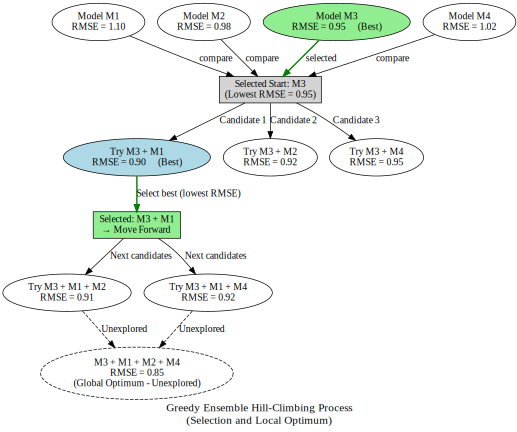

In [ ]:
#@title Digraph: greedy_ensemble_selection
from graphviz import Digraph

dot = Digraph("hill_climb", format="png")
dot.attr(rankdir="TB", size="8,6")  # top to bottom layout

# -------------------------
# Nodes
# -------------------------
dot.node("M1", "Model M1\nRMSE = 1.10", shape="ellipse")
dot.node("M2", "Model M2\nRMSE = 0.98", shape="ellipse")
dot.node("M3", "Model M3\nRMSE = 0.95 ✅ (Best)", shape="ellipse", style="filled", fillcolor="lightgreen")
dot.node("M4", "Model M4\nRMSE = 1.02", shape="ellipse")

# Selection decision (highlight M3 as the best)
dot.node("M3_SELECTED", "Selected Start: M3\n(Lowest RMSE = 0.95)", shape="box", style="filled", fillcolor="lightgray")

# Connect all models to selection node
dot.edge("M1", "M3_SELECTED", label="compare")
dot.edge("M2", "M3_SELECTED", label="compare")
dot.edge("M3", "M3_SELECTED", label="selected", color="green", penwidth="2")
dot.edge("M4", "M3_SELECTED", label="compare")

# Candidate combinations
dot.node("M3_M1", "Try M3 + M1\nRMSE = 0.90 ✅ (Best)", shape="ellipse", fillcolor="lightblue", style="filled")
dot.node("M3_M2", "Try M3 + M2\nRMSE = 0.92", shape="ellipse")
dot.node("M3_M4", "Try M3 + M4\nRMSE = 0.95", shape="ellipse")

# Selected path (M3+M1)
dot.node("M3_M1_FINAL", "Selected: M3 + M1\n→ Move Forward", shape="box", style="filled", fillcolor="lightgreen")

# Next round of attempts
dot.node("M3_M1_M2", "Try M3 + M1 + M2\nRMSE = 0.91 ❌", shape="ellipse")
dot.node("M3_M1_M4", "Try M3 + M1 + M4\nRMSE = 0.92 ❌", shape="ellipse")

# Hidden better combination (global optimum)
dot.node("GLOBAL", "M3 + M1 + M2 + M4\nRMSE = 0.85 ⭐\n(Global Optimum - Unexplored)",
         shape="ellipse", style="dashed")

# -------------------------
# Edges
# -------------------------
# Stage 1: initial model to all candidates
dot.edge("M3_SELECTED", "M3_M1", label="Candidate 1")
dot.edge("M3_SELECTED", "M3_M2", label="Candidate 2")
dot.edge("M3_SELECTED", "M3_M4", label="Candidate 3")

# Selection decision
dot.edge("M3_M1", "M3_M1_FINAL", label="Select best (lowest RMSE)", color="green", penwidth="2")

# Stage 2: new round
dot.edge("M3_M1_FINAL", "M3_M1_M2", label="Next candidates")
dot.edge("M3_M1_FINAL", "M3_M1_M4", label="Next candidates")

# Unexplored global optimum
dot.edge("M3_M1_M2", "GLOBAL", style="dashed", label="Unexplored")
dot.edge("M3_M1_M4", "GLOBAL", style="dashed", label="Unexplored")

# -------------------------
# Render
# -------------------------
dot.attr(label="Greedy Ensemble Hill-Climbing Process\n(Selection and Local Optimum)", fontsize="16")
dot


In [ ]:
#@title Function: greedy_ensemble_selection
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error

def greedy_ensemble_selection(
    pred_wide_val,
    target_col,
    evaluate_fn=None,
    verbose=True,
):
    """
    Greedy (hill-climbing) ensemble selector with flexible user-defined evaluation.

    Parameters
    ----------
    pred_wide_val : pd.DataFrame
        DataFrame containing model predictions and a target column.
        Each row corresponds to a timestamp or sample.
    target_col : str
        Name of the target column in pred_wide_val.
    evaluate_fn : callable, optional
        A function taking (y_true, y_pred) -> float (smaller is better).
        If not provided, defaults to RMSE.
    verbose : bool
        If True, prints progress messages.

    Returns
    -------
    best_models : list of str
        Names of model columns selected for the ensemble.
    best_score : float
        The best (lowest) score achieved by the ensemble.
    """

    # -------------------------------------------------
    # Default evaluation = RMSE if not provided
    # -------------------------------------------------
    if evaluate_fn is None:
        def evaluate_fn(y_true, y_pred):
            return np.sqrt(mean_squared_error(y_true, y_pred))
        if verbose:
            print("Using default metric: RMSE")

    # -------------------------------------------------
    # Initialization
    # -------------------------------------------------
    model_cols = [c for c in pred_wide_val.columns if c != target_col]
    y_true = pred_wide_val[target_col].values

    # Step 1: Evaluate single models
    scores = {m: evaluate_fn(y_true, pred_wide_val[m]) for m in model_cols}
    best_model = min(scores, key=scores.get)
    best_models = [best_model]
    best_score = scores[best_model]
    remaining_models = [m for m in model_cols if m != best_model]

    if verbose:
        print(f"Start with: {best_model} (score={best_score:.5f})")

    # -------------------------------------------------
    # Step 2: Iteratively add models
    # -------------------------------------------------
    improved = True
    while improved and remaining_models:
        improved = False
        stage_results = []

        for m in remaining_models:
            temp_models = best_models + [m]
            y_pred = pred_wide_val[temp_models].mean(axis=1)
            score = evaluate_fn(y_true, y_pred)
            stage_results.append((m, score))

        # Pick model that gives the lowest score
        m_best, score_best = min(stage_results, key=lambda x: x[1])

        if score_best < best_score:
            best_models.append(m_best)
            best_score = score_best
            remaining_models.remove(m_best)
            improved = True
            if verbose:
                print(f"  + Added {m_best}, score improved to {best_score:.5f}")
        else:
            if verbose:
                print("No further improvement — stopping.")

    if verbose:
        print(f"\n✅ Final Ensemble: {best_models}")
        print(f"✅ Final Score: {best_score:.5f}")

    return best_models, best_score


In [ ]:
#@title Synthetic Dataset
import pandas as pd
import numpy as np

np.random.seed(42)

# Parameters
n_customers = 3
n_timestamps = 10
timestamps = pd.date_range("2024-01-01", periods=n_timestamps, freq="D")
models = ["FFT", "Lasso", "LightGBM", "Theta", "XGB_RF"]

# Create one big dataframe
records = []
for cust in range(1, n_customers + 1):
    for t in timestamps:
        # True signal for each customer (slightly different base)
        true_val = 50 + 10 * np.sin(2 * np.pi * (t.dayofyear % 30) / 30) + np.random.normal(0, 2)

        # Model predictions with noise
        preds = {
            "FFT": true_val + np.random.normal(0, 3),
            "Lasso": true_val + np.random.normal(0, 4),
            "LightGBM": true_val + np.random.normal(0, 2),
            "Theta": true_val + np.random.normal(0, 3.5),
            "XGB_RF": true_val + np.random.normal(0, 1.5),
        }

        preds["energy_consumption"] = true_val
        preds["timestamp"] = t
        preds["LCLid"] = f"CUST_{cust:03d}"
        records.append(preds)

pred_wide_val = pd.DataFrame(records).set_index(["LCLid", "timestamp"])
pred_wide_val.head(8)


FFT      Lasso   LightGBM      Theta     XGB_RF  \
LCLid    timestamp                                                           
CUST_001 2024-01-01  52.657752  55.663299  56.118605  52.253008  52.721340   
         2024-01-02  59.528096  55.347895  58.310912  55.603830  56.527197   
         2024-01-03  50.621936  49.462106  55.237202  52.816868  56.833148   
         2024-01-04  51.378489  61.477995  55.163848  55.851749  53.478278   
         2024-01-05  57.904256  52.967514  58.322885  55.469253  57.133948   
         2024-01-06  63.863986  58.253163  56.191730  61.186059  56.475886   
         2024-01-07  54.483936  55.050202  60.756669  62.947579  60.619999   
         2024-01-08  58.810611  53.799834  58.274234  58.101687  61.299606   

                     energy_consumption  
LCLid    timestamp                       
CUST_001 2024-01-01           53.072545  
         2024-01-02           57.225792  
         2024-01-03           56.361777  
         2024-01-04           55.615400  
         2024-01-05           57.571489  
         2024-01-06           58.307152  
         2024-01-07           60.362946  
         2024-01-08           59.713922

In [ ]:
from sklearn.metrics import mean_squared_error
def evaluate_fn(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

In [ ]:
from sklearn.metrics import mean_absolute_error

def mae(y_true, y_pred):
    return mean_absolute_error(y_true, y_pred)

best_models, best_mae = greedy_ensemble_selection(
    pred_wide_val,
    target_col="energy_consumption",
    evaluate_fn=mae
)


Start with: XGB_RF (score=1.28940)
  + Added LightGBM, score improved to 0.83790
No further improvement — stopping.

✅ Final Ensemble: ['XGB_RF', 'LightGBM']
✅ Final Score: 0.83790


## b). Stochastic hill climbing

| Variant                           | Behavior                                                         | When to Stop                                                                     |
| :-------------------------------- | :--------------------------------------------------------------- | :------------------------------------------------------------------------------- |
| **Pure stochastic hill climbing** | Randomly pick one neighbor, move if it improves                  | Continue until *no improving neighbor found after many tries* or iteration limit |
| **Random-restart hill climbing**  | Run stochastic hill climbing *multiple times* from random starts | Keep the best result among runs                                                  |


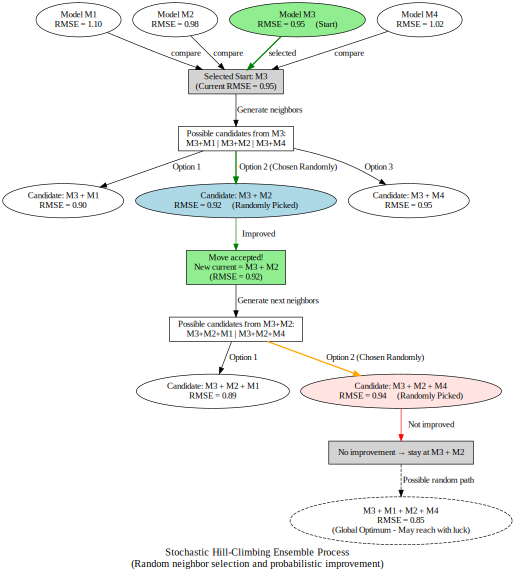

In [ ]:
#@title Digraph: stochastic_hill_climbing (refined)
from graphviz import Digraph

dot = Digraph("stochastic_hill", format="png")
dot.attr(rankdir="TB", size="8,8")

# =========================================================
# Stage 0: Evaluate all individual models
# =========================================================
dot.node("M1", "Model M1\nRMSE = 1.10", shape="ellipse")
dot.node("M2", "Model M2\nRMSE = 0.98", shape="ellipse")
dot.node("M3", "Model M3\nRMSE = 0.95 ✅ (Start)", shape="ellipse", style="filled", fillcolor="lightgreen")
dot.node("M4", "Model M4\nRMSE = 1.02", shape="ellipse")

dot.node("START", "Selected Start: M3\n(Current RMSE = 0.95)", shape="box", style="filled", fillcolor="lightgray")

dot.edge("M1", "START", label="compare")
dot.edge("M2", "START", label="compare")
dot.edge("M3", "START", label="selected", color="green", penwidth="2")
dot.edge("M4", "START", label="compare")

# =========================================================
# Stage 1: Randomly pick a neighbor from M3
# =========================================================
dot.node("CAND_STAGE1",
         "Possible candidates from M3:\nM3+M1 | M3+M2 | M3+M4",
         shape="box", style="filled", fillcolor="white")
dot.edge("START", "CAND_STAGE1", label="Generate neighbors")

# Candidate nodes
dot.node("M3_M1_CAND", "Candidate: M3 + M1\nRMSE = 0.90", shape="ellipse")
dot.node("M3_M2_CAND", "Candidate: M3 + M2\nRMSE = 0.92 ✅ (Randomly Picked)",
         shape="ellipse", style="filled", fillcolor="lightblue")
dot.node("M3_M4_CAND", "Candidate: M3 + M4\nRMSE = 0.95", shape="ellipse")

# Connect them
dot.edge("CAND_STAGE1", "M3_M1_CAND", label="Option 1")
dot.edge("CAND_STAGE1", "M3_M2_CAND", label="Option 2 (Chosen Randomly)", color="green", penwidth="2")
dot.edge("CAND_STAGE1", "M3_M4_CAND", label="Option 3")

# Move accepted
dot.node("ACCEPT1", "Move accepted!\nNew current = M3 + M2\n(RMSE = 0.92)",
         shape="box", style="filled", fillcolor="lightgreen")
dot.edge("M3_M2_CAND", "ACCEPT1", label="Improved ✓", color="green")

# =========================================================
# Stage 2: Randomly pick next neighbor from M3+M2
# =========================================================
dot.node("CAND_STAGE2",
         "Possible candidates from M3+M2:\nM3+M2+M1 | M3+M2+M4",
         shape="box", style="filled", fillcolor="white")
dot.edge("ACCEPT1", "CAND_STAGE2", label="Generate next neighbors")

# Candidate nodes
dot.node("M3_M2_M1_CAND", "Candidate: M3 + M2 + M1\nRMSE = 0.89", shape="ellipse")
dot.node("M3_M2_M4_CAND", "Candidate: M3 + M2 + M4\nRMSE = 0.94 ❌ (Randomly Picked)",
         shape="ellipse", style="filled", fillcolor="mistyrose")

# Connect them
dot.edge("CAND_STAGE2", "M3_M2_M1_CAND", label="Option 1")
dot.edge("CAND_STAGE2", "M3_M2_M4_CAND", label="Option 2 (Chosen Randomly)", color="orange", penwidth="2")

# Evaluate and reject if worse
dot.node("REJECT", "No improvement → stay at M3 + M2", shape="box", style="filled", fillcolor="lightgray")
dot.edge("M3_M2_M4_CAND", "REJECT", label="Not improved ✗", color="red")

# =========================================================
# Hidden global optimum (same as before)
# =========================================================
dot.node("GLOBAL", "M3 + M1 + M2 + M4\nRMSE = 0.85 ⭐\n(Global Optimum - May reach with luck)",
         shape="ellipse", style="dashed")
dot.edge("REJECT", "GLOBAL", style="dashed", label="Possible random path")

# =========================================================
# Render and label
# =========================================================
dot.attr(label="Stochastic Hill-Climbing Ensemble Process\n(Random neighbor selection and probabilistic improvement)", fontsize="16")
dot


In [ ]:
#@title Function: stochastic_ensemble_selection
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
import random

def stochastic_ensemble_selection(
    pred_wide_val,
    target_col,
    evaluate_fn=None,
    max_iterations=50,
    random_state=None,
    verbose=True,
):
    """
    Stochastic hill-climbing ensemble selector.
    Randomly picks a candidate model each step and accepts it if the
    new ensemble improves the score.

    Parameters
    ----------
    pred_wide_val : pd.DataFrame
        DataFrame containing model predictions and a target column.
        Each row corresponds to a timestamp or sample.
    target_col : str
        Name of the target column in pred_wide_val.
    evaluate_fn : callable, optional
        A function taking (y_true, y_pred) -> float (smaller is better).
        If not provided, defaults to RMSE.
    max_iterations : int, default=50
        Maximum number of random trials.
    random_state : int, optional
        Random seed for reproducibility.
    verbose : bool, default=True
        If True, prints progress messages.

    Returns
    -------
    best_models : list of str
        Models included in the best ensemble found.
    best_score : float
        Best (lowest) score achieved.
    history : list of dict
        Iteration-wise log of scores, candidates, and acceptance decisions.
    """

    # -------------------------------------------------
    # Setup
    # -------------------------------------------------
    if random_state is not None:
        random.seed(random_state)
        np.random.seed(random_state)

    if evaluate_fn is None:
        def evaluate_fn(y_true, y_pred):
            return np.sqrt(mean_squared_error(y_true, y_pred))
        if verbose:
            print("Using default metric: RMSE")

    model_cols = [c for c in pred_wide_val.columns if c != target_col]
    y_true = pred_wide_val[target_col].values

    # Step 1: Start from the best single model
    scores = {m: evaluate_fn(y_true, pred_wide_val[m]) for m in model_cols}
    best_model = min(scores, key=scores.get)
    best_models = [best_model]
    best_score = scores[best_model]

    if verbose:
        print(f"Start with: {best_model} (score={best_score:.5f})")

    # -------------------------------------------------
    # Step 2: Randomized search (stochastic hill climbing)
    # -------------------------------------------------
    history = []
    for i in range(max_iterations):
        remaining_models = [m for m in model_cols if m not in best_models]
        if not remaining_models:
            if verbose:
                print("All models have been used — stopping.")
            break

        candidate = random.choice(remaining_models)
        temp_models = best_models + [candidate]
        y_pred = pred_wide_val[temp_models].mean(axis=1)
        score = evaluate_fn(y_true, y_pred)

        accepted = False
        if score < best_score:
            # Accept the move
            best_models.append(candidate)
            best_score = score
            accepted = True
            if verbose:
                print(f"[Iter {i+1:02d}] Randomly picked {candidate}: improved ✓ (score={best_score:.5f})")
        else:
            # Reject the move
            if verbose:
                print(f"[Iter {i+1:02d}] Randomly picked {candidate}: no improvement ✗ (score={score:.5f})")

        history.append({
            "iteration": i + 1,
            "candidate": candidate,
            "accepted": accepted,
            "score": score,
            "best_score": best_score,
            "current_ensemble": best_models.copy(),
        })

    if verbose:
        print(f"\n✅ Final Ensemble: {best_models}")
        print(f"✅ Final Score: {best_score:.5f}")

    return best_models, best_score, history


In [ ]:
best_models, best_score, history = stochastic_ensemble_selection(
    pred_wide_val,
    target_col="energy_consumption",
    max_iterations=3,
    random_state=42
)


Using default metric: RMSE
Start with: LightGBM (score=1.67329)
[Iter 01] Randomly picked FFT: no improvement ✗ (score=1.78816)
[Iter 02] Randomly picked FFT: no improvement ✗ (score=1.78816)
[Iter 03] Randomly picked Theta: improved ✓ (score=1.49676)

✅ Final Ensemble: ['LightGBM', 'Theta']
✅ Final Score: 1.49676


## c). Optimal Weighted Ensemble

In [ ]:
from scipy import optimize
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error

def find_optimal_combination(
    candidates,
    pred_wide,
    target,
    metric_fn=mean_absolute_error,
    verbose=True,
):
    """Find optimal non-negative weights (sum=1) minimizing forecast error."""

    def loss_function(weights):
        fc = np.sum(pred_wide[candidates].values * np.array(weights), axis=1)
        return metric_fn(pred_wide[target].values, fc)

    n = len(candidates)
    init_w = np.ones(n) / n

    constraints = {"type": "eq", "fun": lambda w: np.sum(w) - 1}
    bounds = [(0.0, 1.0)] * n

    res = optimize.minimize(
        loss_function,
        x0=init_w,
        bounds=bounds,
        constraints=constraints,
        method="SLSQP",
        options={"ftol": 1e-9, "disp": False},
    )

    weights = res.x

    if verbose:
        print(f"Optimization success: {res.success}")
        print(f"Optimal Weights: {dict(zip(candidates, np.round(weights, 4)))}")
        print(f"Minimum {metric_fn.__name__}: {res.fun:.5f}")

    return weights

# Example usage
candidates = ["FFT", "Lasso", "LightGBM", "Theta", "XGB_RF"]
optimal_weights = find_optimal_combination(
    candidates=candidates,
    pred_wide=pred_wide_val,
    target="energy_consumption",
    metric_fn=mean_absolute_error,
)

weights_df = pd.DataFrame(optimal_weights, index=candidates, columns=['weight'])
display(weights_df)

Optimization success: True
Optimal Weights: {'FFT': np.float64(0.1158), 'Lasso': np.float64(0.1064), 'LightGBM': np.float64(0.3912), 'Theta': np.float64(0.1353), 'XGB_RF': np.float64(0.2513)}
Minimum mean_absolute_error: 0.68611


,weight
FFT,0.115790
Lasso,0.106405
LightGBM,0.391153
Theta,0.135343
XGB_RF,0.251309


# Model Config

In [ ]:
#@title FeatureConfig

@dataclass
class FeatureConfig:
    """FeatureConfig describe data, not how to transform it."""

    continuous_features: List
    date: List = None
    target: str = None

    categorical_features: List = None
    boolean_features: List[str] = None

    exogenous_features: List[str] = field(
        default_factory=list,
        metadata={
            "help": (
                        "These features are not the target but may influence it. "
                        "Each must already be declared in either 'continuous_features' or 'categorical_features'."
                    ) } )
    original_target = None

    def __post_init__(self):
        """Validate feature configuration after initialization."""

        all_features = ( self.categorical_features + self.continuous_features + self.boolean_features )

        # --- 1. Ensure target/date are not included in features
        if self.target in all_features:
            raise ValueError( f"Target column `{self.target}` must not appear in categorical, continuous, or boolean features." )

        if self.date in all_features:
            raise ValueError( f"Date column `{self.date}` must not appear in categorical, continuous, or boolean features." )

        # --- 2. Validate exogenous features
        extra_exog = set(self.exogenous_features) - set(all_features)
        if extra_exog:
            raise ValueError(
                f"Exogenous features not present in declared features: {sorted(extra_exog)}"
            )

        # --- 3. Ensure no overlaps between feature types
        overlaps = (
                        set(self.continuous_features) & set(self.categorical_features)
                    ) | (
                        set(self.continuous_features) & set(self.boolean_features)
                    ) | (
                        set(self.categorical_features) & set(self.boolean_features)
                    )

        if overlaps:
            raise ValueError(
                f"Features cannot belong to multiple types. Overlapping features: {sorted(overlaps)}"
            )
            # --- 6. Default original_target if missing
        if self.original_target is None:
            self.original_target = self.target

    def get_X_y(
        self,
        df: pd.DataFrame,
        categorical: bool = False,
        exogenous: bool = False
    ):
        """
        Slice a dataframe into X, y, y_orig using the configured feature groups.

        Parameters
        ----------
        df : pd.DataFrame
            Source dataframe containing features and target(s).
        categorical : bool
            If True, include categorical + boolean features in X (in addition to continuous).
        exogenous : bool
            If True, keep `exogenous_features` in X; otherwise drop them.

        Returns
        -------
        (X, y, y_orig)
            X : pd.DataFrame of selected features
            y : pd.DataFrame with the target column (or None if missing)
            y_orig : pd.DataFrame with the original target column (or None if missing)
        """
        # 1) Build list of expected features
        feature_list = list(self.continuous_features)  # start with continuous
        if categorical:
            feature_list += self.categorical_features + self.boolean_features
        if not exogenous:
            feature_list = [f for f in feature_list if f not in set(self.exogenous_features)]

        # 2) Validate all required features exist
        missing = set(feature_list) - set(df.columns)
        if missing:
            warnings.warn(f"Missing features dropped: { missing }")
        feature_list = [f for f in feature_list if f in df.columns]

        # 3) Slice
        X = df.loc[:, feature_list].copy()
        y = df[[self.target]].copy() if self.target in df.columns else None
        y_orig = df[[self.original_target]].copy() if self.original_target in df.columns else None

        return X, y, y_orig



In [ ]:
#@title ModelConfig
from sklearn.base import BaseEstimator, clone
from sklearn.preprocessing import StandardScaler

@dataclass
class ModelConfig:

    # Models
    model: BaseEstimator = field(
        default=MISSING, metadata={"help": "Sci-kit Learn Compatible model instance"}
    )

    name: str = field(
        default=None,
        metadata={
            "help": "Name or identifier for the model. If left None, will use the string representation of the model"
        },
    )

    # Continuous features preprocessing
    apply_normalization: bool = field(
        default=False,
        metadata={"help": "Whether to normalize continuous features before fitting"}
    )

    scaler_model: Optional[BaseEstimator] = field(
        default=None,
        metadata={"help": "Scaler object to be used for continuous features (e.g., StandardScaler, MinMaxScaler)"}
    )

    # Categorical features preprocessing
    apply_categorical_encoding: bool = field(
        default=False,
        metadata={"help": "Whether to encode categorical features before fitting"}
    )

    categorical_encoder_model: Optional[BaseEstimator] = field(
        default=None,
        metadata={"help": "Encoder object for categorical features (e.g., OneHotEncoder, OrdinalEncoder)"}
    )

    def __post_init__(self):

        if self.model is MISSING:
            raise ValueError("`model` must be provided.")

        if self.apply_normalization and self.scaler_model is None:
            warnings.warn(
                            "`apply_normalization=True` but no scaler_model was provided. "
                            "Defaulting to StandardScaler()."
                        )
            self.scaler_model = StandardScaler()

        if self.apply_categorical_encoding and self.categorical_encoder_model is None:
            raise ValueError("`apply_categorical_encoding=True` but no categorical_encoder_model provided.")

        if self.name is None:
            self.name = str(self.model)

        # Type safety checks
        if self.scaler_model is not None and not isinstance(self.scaler_model, BaseEstimator):
            raise TypeError("scaler_model must be a scikit-learn estimator.")
        if self.categorical_encoder_model is not None and not isinstance(self.categorical_encoder_model, BaseEstimator):
            raise TypeError("categorical_encoder_model must be a scikit-learn estimator.")


    def clone(self):
      # creates a fresh copy of the estimator with the same hyperparameters but without any fitted state.
        self.model = clone(self.model)
        return self


In [ ]:
#@title ModelWorkflow

import copy
import warnings
import numpy as np
import pandas as pd
from sklearn.base import clone
from sklearn.preprocessing import StandardScaler, OneHotEncoder

class ModelWorkflow:
    def __init__(
        self,
        model_config,
        feature_config,
        target_transformer: object = None,
    ) -> None:
        """
        Execution workflow wrapping a scikit-learn style estimator
        with preprocessing and optional target transformation.
        """
        self.model_config = model_config
        self.feature_config = feature_config
        self.target_transformer = target_transformer

        # clone model
        self._model = clone(self.model_config.model)

        # runtime state
        self._scaler = None
        self._cat_encoder = None
        self._encoded_categorical_features = None

        # keep track of last datasets for evaluation
        self._last_train_df = None
        self._last_test_df = None
        self._last_y_pred = None

        # initialize scaler if needed
        if self.model_config.apply_normalization:
            self._scaler = clone(self.model_config.scaler_model)

        # initialize categorical encoder if needed
        if self.model_config.apply_categorical_encoding:
            if self.model_config.categorical_encoder_model is None:
                warnings.warn(
                    "`apply_categorical_encoding=True` but no encoder set. "
                    "Defaulting to OneHotEncoder(handle_unknown='ignore')."
                )
                self._cat_encoder = OneHotEncoder(handle_unknown="ignore")
            else:
                self._cat_encoder = clone(self.model_config.categorical_encoder_model)
            self._encoded_categorical_features = copy.deepcopy(
                self.feature_config.categorical_features
            )

    # -------------------------------
    # Categorical encoding
    # -------------------------------
    def _encode_categorical_fit(self, X: pd.DataFrame) -> None:
        if self._cat_encoder is not None and self._encoded_categorical_features:
            self._cat_encoder.fit(X[self._encoded_categorical_features])

    def _encode_categorical_transform(self, X: pd.DataFrame) -> pd.DataFrame:
        if self._cat_encoder is None or not self._encoded_categorical_features:
            return X
        encoded = self._cat_encoder.transform(X[self._encoded_categorical_features])
        encoded_cols = self._cat_encoder.get_feature_names_out(self._encoded_categorical_features)
        X_encoded = pd.DataFrame(encoded, columns=encoded_cols, index=X.index)

        # drop original categorical cols, add encoded ones
        X = X.drop(columns=self._encoded_categorical_features)
        return pd.concat([X, X_encoded], axis=1)

    # -------------------------------
    # Scaling
    # -------------------------------
    def _scale_features_fit(self, X: pd.DataFrame) -> None:
        if self._scaler is not None and self.feature_config.continuous_features:
            self._scaler.fit(X[self.feature_config.continuous_features])

    def _scale_features_transform(self, X: pd.DataFrame) -> pd.DataFrame:
        if self._scaler is None or not self.feature_config.continuous_features:
            return X
        scaled = self._scaler.transform(X[self.feature_config.continuous_features])
        X_scaled = pd.DataFrame(scaled, columns=self.feature_config.continuous_features, index=X.index)
        X = X.copy()
        X[self.feature_config.continuous_features] = X_scaled
        return X

    # -------------------------------
    # Target transformation
    # -------------------------------
    def _transform_target_fit(self, y: pd.Series) -> np.ndarray:
        if self.target_transformer is None:
            return y.values
        return self.target_transformer.fit_transform(y.values.reshape(-1, 1)).ravel()

    def _inverse_transform_target(self, y_pred: np.ndarray) -> np.ndarray:
        if self.target_transformer is None:
            return y_pred
        return self.target_transformer.inverse_transform(y_pred.reshape(-1, 1)).ravel()

    # -------------------------------
    # Public API
    # -------------------------------
    def fit(self, df: pd.DataFrame, categorical=True, exogenous=True):
        """Full workflow: extract features & target, preprocess, fit model."""
        X, y, _ = self.feature_config.get_X_y(df, categorical=categorical, exogenous=exogenous)
        self._last_train_df = df.copy()

        return self.fit_Xy(X, y)

    def fit_Xy(self, X: pd.DataFrame, y: pd.Series):
        """Lower-level fit if you already have X and y."""
        # categorical encoding
        self._encode_categorical_fit(X)
        X_proc = self._encode_categorical_transform(X)

        # scaling
        self._scale_features_fit(X_proc)
        X_proc = self._scale_features_transform(X_proc)

        # target transform
        y_proc = self._transform_target_fit(y)

        # fit model
        self._model.fit(X_proc, y_proc)
        return self

    def predict(self, df: pd.DataFrame, categorical=True, exogenous=True) -> np.ndarray:
        """Predict from raw dataframe and store test set + predictions."""
        X, _, _ = self.feature_config.get_X_y(df, categorical=categorical, exogenous=exogenous)
        y_pred = self.predict_X(X)
        self._last_test_df = df.copy()
        self._last_y_pred = pd.Series(y_pred.ravel(), index=df.index)
        return y_pred

    def predict_X(self, X: pd.DataFrame) -> np.ndarray:
        """Predict from pre-extracted features."""
        X_proc = self._encode_categorical_transform(X)
        X_proc = self._scale_features_transform(X_proc)
        y_pred = self._model.predict(X_proc)
        return self._inverse_transform_target(y_pred)

    def feature_importance(self) -> pd.DataFrame:
        """Return feature importances or coefficients if available."""
        if hasattr(self._model, "feature_importances_"):
            values = self._model.feature_importances_
            features = self._model.feature_names_in_
        elif hasattr(self._model, "coef_"):
            values = self._model.coef_
            features = self._model.feature_names_in_
        else:
            raise AttributeError("Model has no feature_importances_ or coef_")

        return pd.DataFrame({"feature": features, "importance": values})

    def evaluate(self, decimals: int = 3) -> Dict[str, float]:
        """
        Evaluate using the last train/test/predict calls.
        Requires fit() and predict() to have been called first.
        """
        if self._last_train_df is None or self._last_test_df is None or self._last_y_pred is None:
            raise ValueError("You must call fit() and predict() before evaluate().")

        # Extract y_true and y_train
        _, y_test, _ = self.feature_config.get_X_y(self._last_test_df)
        _, y_train, _ = self.feature_config.get_X_y(self._last_train_df)

        return calculate_metrics(
            y=y_test,
            y_pred=self._last_y_pred,
            name=self.model_config.name,
            y_train=y_train,
            decimals=decimals,
        )




In [ ]:
feature_config = FeatureConfig(
                                date = feature_dict['date'],
                                continuous_features = feature_dict['continuous_features'],
                                categorical_features = feature_dict['categorical_features'],  # overlap on purpose
                                boolean_features = feature_dict['boolean_features'],
                                exogenous_features = feature_dict['exogenous_features'],
                                target="energy_consumption",
                            )



In [ ]:
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder


model_config = ModelConfig(
    model=Ridge(),
    apply_normalization=True,
    scaler_model=StandardScaler(),
    apply_categorical_encoding=True,
    categorical_encoder_model=OneHotEncoder(handle_unknown="ignore", sparse_output=False)
)


In [ ]:
workflow = ModelWorkflow(model_config=model_config, feature_config=feature_config)


workflow.fit(sample_train_df)

y_pred = workflow.predict(sample_test_df).ravel()


workflow.evaluate()


{'Algorithm': 'Ridge()',
 'MAE': np.float64(0.167),
 'RMSE': np.float64(0.275),
 'WAPE': np.float64(0.477),
 'MASE': np.float64(1.302),
 'Forecast Bias(%)': np.float64(4.247)}